# Pronósticos de demanda diaria con LSTM usando Keras y TensorFlow

## Pronósticos a partir de la serie temporal de la demanda diaria incorporando variables exógenas desde Datasets

La propuesta es dar pronósticos de la demanda diaria de energía eléctrica a partir de sus valores registrados en días anteriores y de otros atributos que podrían tener influencia (variables exógenas) alamcenados en `tf.data.Dataset`. 

Continuaremos con nuestro ejemplo tomando la base de datos de demanda diaria de energía eléctrica publicados por CAMMESA. 

## Inicio de la programación para el análisis y pronóstico de la serie temporal

Comenzamos importando las bibliotecas necesarias y confirmamos la versión de TensorFlow (TF) disponible en la instalación. Esto nos puede ayudar a interpretar algunas diferencias en el comportamiento de las funciones de TF.

In [1]:
import datetime
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

import keras
import tensorflow as tf
tf.random.set_seed(99)
print(tf.__version__)

2026-02-06 18:22:33.137872: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.18.0


## Carga del conjunto de datos para su análisis

Cargamos los datos de demanda diaria. DEMANDA TOTAL es la serie que queremos predecir (target). Esperamos que sus valores históricos nos provean información para su pronóstico. Además, tomaremos otros atributos que consideramos relevantes como `TEMPERATURA REFERENCIA MEDIA GBA °C` o `Tipo día` que nos informa si la jornada fue laborable, semilaborable o no laborable. Las columnas que se refieren a los registros de demanda para otras regiones argentinas no las consideraremos.

In [2]:
# Dataset loading
dataFrame = pd.read_excel('Data/Base Demanda Diaria 2017 2024.xlsx', sheet_name='Datos Región', skiprows=4)  
dataFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2891 entries, 0 to 2890
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   AÑO                                  2891 non-null   int64         
 1   MES                                  2891 non-null   datetime64[ns]
 2   Fecha                                2891 non-null   datetime64[ns]
 3   Tipo día                             2891 non-null   object        
 4   GRAN BS.AS.                          2891 non-null   float64       
 5   BUENOS AIRES                         2891 non-null   float64       
 6   CENTRO                               2891 non-null   float64       
 7   LITORAL                              2891 non-null   float64       
 8   CUYO                                 2891 non-null   float64       
 9   NOROESTE                             2891 non-null   float64       
 10  NORESTE     

### Separación de los conjuntos de datos de entrenamiento, validación y prueba

Como es habitual, separamos el conjunto de datos en entrenamiento y prueba. Como sabemos, se reserva una porción del final de la serie temporal como datos de prueba. En este ejercicio, desdoblamos en datos numéricos y categóricos.

In [3]:

# TensorFlow tensors require that all elements have the same dtype.
numeric_feature_names = ['DEMANDA TOTAL', 'TEMPERATURA REFERENCIA MEDIA GBA °C']
column_indices = {name: i for i, name in enumerate(numeric_feature_names)}
numeric_tensor = np.float32(dataFrame[numeric_feature_names].to_numpy())
# cast to tf defaults... float32

categoric_feature_names = ['Tipo día']
categoric_tensor = dataFrame[categoric_feature_names].to_numpy()



En lo siguiente utilizaremos `tf.keras.preprocessing.timeseries_dataset_from_array` que crea conjuntos de datos de ventanas móviles sobre series temporales provistas como arrays. Por esto mantenemos en el paso anterior la transformación `.to_numpy()`. 

## Alternativas para time series windows

usando `.batch()` y `.window()`

TF: Build TensorFlow input pipelines

[Time series windowing](https://www.tensorflow.org/guide/data#time_series_windowing)

## Ventanas de datos




Necesitamos particionar la serie temporal en lotes operables por las sucesivas capas de NN. En este ejemplo tomaremos funciones desarrolladas específicamente para operar con series temporales en lugar de definir nuestras propias funciones que realizan los cortes en lotes de datos.

Como lo adelantamos, `tf.keras.preprocessing.timeseries_dataset_from_array` toma una secuencia de datos reunidos en intervalos iguales, junto con parámetros de la serie temporal como longitud de la secuencia/ventana, espaciamiento de la secuencia/ventana, etc., para producir lotes de series temporales de datos de entrada y de de targets.


In [4]:

def make_dataset(data, target_idx=0, out_len=28, ts_num=28):
    input_data = data[:-ts_num]
    if target_idx is not None:
        targets = data[ts_num:, target_idx]
        targets = targets[...,np.newaxis]
    else:
        targets = None
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=input_data,
        targets=targets,
        sequence_length=out_len, #Length of the output sequences (in number of timesteps). 
        sequence_stride=1, #Period between successive output sequences
        shuffle=False,
        batch_size=ts_num, #Number of timeseries samples in each batch
        seed=43)
    return ds


Pasamos un 0 a la función `make_dataset` ya que las estiquetas están en la columna 0. Por esto, la función devuelve `Dataset` como una tupla con 2 tensores: el tensor de atributos (2 columnas de atributos, demanda y temperatura media) y el de etiquetas (valor de la demanda desplazada al final de `SEQ_LENGTH).

In [5]:
BATCH_SIZE=28
SEQ_LENGTH=28
num_attr_ds = make_dataset(numeric_tensor, 0, SEQ_LENGTH, BATCH_SIZE)
num_attr_ds.element_spec

(TensorSpec(shape=(None, None, 2), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))

Creamos un `Dataset` con los datos categóricos. Pasamos `None` ya que las etiquetas se definieron en el paso anterior. Recuperamos otro tensor de atributos (en este caso de tipo `tf.string`)

In [6]:
cattr_ds = make_dataset(categoric_tensor, None, SEQ_LENGTH, BATCH_SIZE)
cattr_ds.element_spec

TensorSpec(shape=(None, None, 1), dtype=tf.string, name=None)

Vamos a formar un diccionario de `Datasets`. Esto permite combinar los distintos tipo de tensores y que sean ingestables por el modelo.

In [7]:
nattr_ds = num_attr_ds.map(lambda X, y: X)
tgt_ds = num_attr_ds.map(lambda X, y: y)

#dict_ds = tf.data.Dataset.from_tensor_slices(({"num_input": nattr_ds}, {"output": tgt_ds},))
#dict_ds = tf.data.Dataset.from_tensor_slices((nattr_ds, tgt_ds))
# dict_ds = tf.data.Dataset.zip((nattr_ds, tgt_ds))
dict_ds = tf.data.Dataset.zip({'num_input': nattr_ds, 'cat_input': cattr_ds}, {'output': tgt_ds})
DATASET_SIZE = dict_ds.cardinality().numpy()
print(DATASET_SIZE)
dict_ds.element_spec



102


({'num_input': TensorSpec(shape=(None, None, 2), dtype=tf.float32, name=None),
  'cat_input': TensorSpec(shape=(None, None, 1), dtype=tf.string, name=None)},
 {'output': TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)})

Separamos en datos de entrenamiento, validación y prueba

In [8]:
train_size = int(0.82 * DATASET_SIZE)
val_size = int(0.1 * DATASET_SIZE)


train_ds = dict_ds.take(train_size)
val_ds = dict_ds.skip(train_size).take(val_size)
test_ds = dict_ds.skip(train_size).skip(val_size)



In [9]:
for batch in train_ds.take(5):
    inputs, outputs = batch
    # outputs = outputs[...,tf.newaxis]
    print(inputs.keys(), outputs.keys())

print('Input: ', inputs['num_input'].shape)
print('Input: ', inputs['cat_input'].shape)
print('Output: ', outputs['output'].shape)

dict_keys(['num_input', 'cat_input']) dict_keys(['output'])
dict_keys(['num_input', 'cat_input']) dict_keys(['output'])
dict_keys(['num_input', 'cat_input']) dict_keys(['output'])
dict_keys(['num_input', 'cat_input']) dict_keys(['output'])
dict_keys(['num_input', 'cat_input']) dict_keys(['output'])
Input:  (28, 28, 2)
Input:  (28, 28, 1)
Output:  (28, 1)


2026-02-06 18:22:35.973857: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Confirmamos los tamaños de los nuevos conjuntos de datos particionados en lotes.

Ahora no es necesario separar en atributos (`X`) y targets (`y`), solo debemos pasar los `Datasets` de entrenamiento o prueba

### Adaptar para normalizar los atributos numéricos 

In [10]:
# Normalize numeric features
normalize_layer = keras.layers.Normalization(axis=2)
normalize_layer.adapt(train_ds.map(lambda X, y: X['num_input']))
normalize_layer.get_config()

2026-02-06 18:22:36.315186: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'name': 'normalization',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'axis': (2,),
 'invert': False,
 'mean': None,
 'variance': None}

Podemos conocer la media y la varianza que luego podríamos usar para invertir los resultados

In [11]:
print('DEMANDA TOTAL - Mean: {0:.0f}, Std.Dev {1:.0f}'.format(normalize_layer.mean[0,0,0],
                                                           np.sqrt(normalize_layer.variance[0,0,0])))
print('Temperatura - Mean: {0:.1f}, Std.Dev. {1:.1f}'.format(normalize_layer.mean[0,0,1],
                                                             np.sqrt(normalize_layer.variance[0,0,1])))

DEMANDA TOTAL - Mean: 15200, Std.Dev 2072
Temperatura - Mean: 19.0, Std.Dev. 5.7


### Agregando la capa custom de preprocesado para los atributos categóricos

In [12]:
# Our definition for the categorical preporcossing layer
class OneHotPre(keras.layers.Layer):
    def __init__(self, max_tokens, vocabulary=None, num_oov_indices=0, **kwargs):
        self._lower_lyr = tf.keras.layers.Lambda(lambda x: tf.strings.lower(x))
        self._lab_lyr = tf.keras.layers.Lambda(lambda x: 
                                           tf.strings.regex_replace(x, '^.*h.bil.*$', 'laborable'))
        self._semilab_lyr = tf.keras.layers.Lambda(lambda x:
                                                   tf.strings.regex_replace(x,'^.*semilaborable.*$', 'semilaborable'))
        self._nolab_lyr = tf.keras.layers.Lambda(lambda x:
                                                 tf.strings.regex_replace(x,'^.*feriado.*$', 'nolaborable'))
        self._lookup_layer = tf.keras.layers.StringLookup(
            max_tokens = max_tokens,
            num_oov_indices = num_oov_indices,
            vocabulary = vocabulary,
            # output_mode = 'int')
            output_mode = 'one_hot')
        super().__init__(**kwargs)
    def _to_day_type(self, value):
        day_type = self._lower_lyr(value)
        day_type = self._lab_lyr(day_type)
        day_type = self._semilab_lyr(day_type)
        return self._nolab_lyr(day_type)
    def adapt(self, data_sample):
        map_ds = data_sample.map(lambda x: self._lower_lyr(x))
        map_ds = map_ds.map(lambda x: self._lab_lyr(x))
        map_ds = map_ds.map(lambda x: self._semilab_lyr(x))
        map_ds = map_ds.map(lambda x: self._nolab_lyr(x))
        self._lookup_layer.adapt(map_ds)
        # self._lookup_layer.adapt(data_sample)
    def call(self, inputs):
        # return self._lookup_layer(self._to_day_type(inputs))
        ll = self._lower_lyr(inputs)
        ll = self._lab_lyr(ll)
        ll = self._semilab_lyr(ll)
        ll = self._nolab_lyr(ll)
        return self._lookup_layer(ll)
    def get_config(self):
        return {'vocabulary': self._lookup_layer.get_vocabulary()}

### Adaptando la capa custom para preprocesar los attributos categóricos

In [13]:
index=0
one_hot_layer = OneHotPre(3)
one_hot_layer.adapt(train_ds.map(lambda X, y: X['cat_input']))
one_hot_layer.get_config()

#one_hot_layer = OneHotPre(index, 7, ['Domingo o Feriado',
#                                     'Sabado o Semilaborable', 
#                                     'Miercoles habiles', 
#                                     'Jueves Habiles', 
#                                     'Martes Habiles',
#                                     'Viernes habiles',
#                                     'Lunes habiles'])
one_hot_layer.get_config()

{'vocabulary': [np.str_('laborable'),
  np.str_('nolaborable'),
  np.str_('semilaborable')]}

In [14]:
for batch in train_ds.take(1):
    inputs, outputs = batch
    print(inputs['cat_input'].shape)
    print(inputs['num_input'].shape)
    other=one_hot_layer(inputs['cat_input'])
    other2=normalize_layer(inputs['num_input'])
    print(other.shape)
    print(other2.shape)
    print(other.dtype)



(28, 28, 1)
(28, 28, 2)
(28, 28, 3)
(28, 28, 2)
<dtype: 'int64'>


2026-02-06 18:22:37.033266: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Definición del modelo 



En este caso, definimos el modelo de manera que procese la información de entrada por 2 canales diferentes. Los datos numéricos se normalizan, los categóricos pasan por la capa custom de codificación one-hot. Luego, ambas salidas se unen para continuar su procesamiento en la primer capa con celdas LSTM. 


## Como pasar multiples datos de entrada desde un Dataset

TF: Training & evaluation with the built-in methods 

the Dataset should return a tuple of dicts.

[Passing data to multi-input, multi-output models](https://www.tensorflow.org/guide/keras/training_with_built_in_methods#passing_data_to_multi-input_multi-output_models)

y también ver TF: The Functional API

When calling fit with a Dataset object, it should yield either a tuple of lists like `([title_data, body_data, tags_data], [priority_targets, dept_targets])` or a tuple of dictionaries like `({'title': title_data, 'body': body_data, 'tags': tags_data}, {'priority': priority_targets, 'department': dept_targets})`.

[Manipulate complex graph topologies](https://www.tensorflow.org/guide/keras/functional_api#manipulate_complex_graph_topologies)

In [15]:
unnormalize_layer = keras.layers.Normalization(axis=1, mean=normalize_layer.mean[0,0,0],
                                              variance=normalize_layer.variance[0,0,0],
                                               invert=True, name='output')

# Functional API Model 
numeric_input = keras.layers.Input(shape=(SEQ_LENGTH, 2), dtype=tf.float32, name='num_input')
normalized = normalize_layer(numeric_input)
categorical_input = keras.layers.Input(shape=(SEQ_LENGTH, 1), dtype=tf.string, name='cat_input')
encoded = one_hot_layer(categorical_input)
reshape_layer = tf.keras.layers.Reshape((SEQ_LENGTH,3))(encoded)
concat = keras.layers.concatenate([normalized, reshape_layer])
lstm_lyr = keras.layers.LSTM(10)(concat)
dropout_lyr = keras.layers.Dropout(0.2)(lstm_lyr)
dense_lyr = keras.layers.Dense(1, activation='linear')(dropout_lyr)
unnormalized = unnormalize_layer(dense_lyr)
model_exo = keras.models.Model(inputs=[numeric_input, categorical_input], outputs=[unnormalized])
model_exo.compile(loss = 'MeanSquaredError', metrics=['MAE'], optimizer='Adam')
# model_exo.compile(loss = {'output': tf.keras.losses.MeanSquaredError()},
#                  metrics={'output': tf.keras.metrics.MeanAbsoluteError()},
#                  optimizer='Adam')
model_exo.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cat_input           │ (None, 28, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num_input           │ (None, 28, 2)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ one_hot_pre         │ (None, 28, 3)     │          0 │ cat_input[0][0]   │
│ (OneHotPre)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 28, 2)     │          5 │ num_input[0][0]   │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 28, 3)     │          0 │ one_hot_pre[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 28, 5)     │          0 │ normalization[0]… │
│ (Concatenate)       │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 10)        │        640 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 10)        │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │         11 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 1)         │          0 │ dense[0][0]       │
│ (Normalization)     │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 656 (2.57 KB)

 Trainable params: 651 (2.54 KB)

 Non-trainable params: 5 (24.00 B)

El método `.summary()` nos muestra cómo fluirá la información entre las capas de NN y cuántos parámetros se deberán ajustar en cada una. Otra alternativa para representar la configuración de la NN es usar `tf.keras.utils.plot_model`.

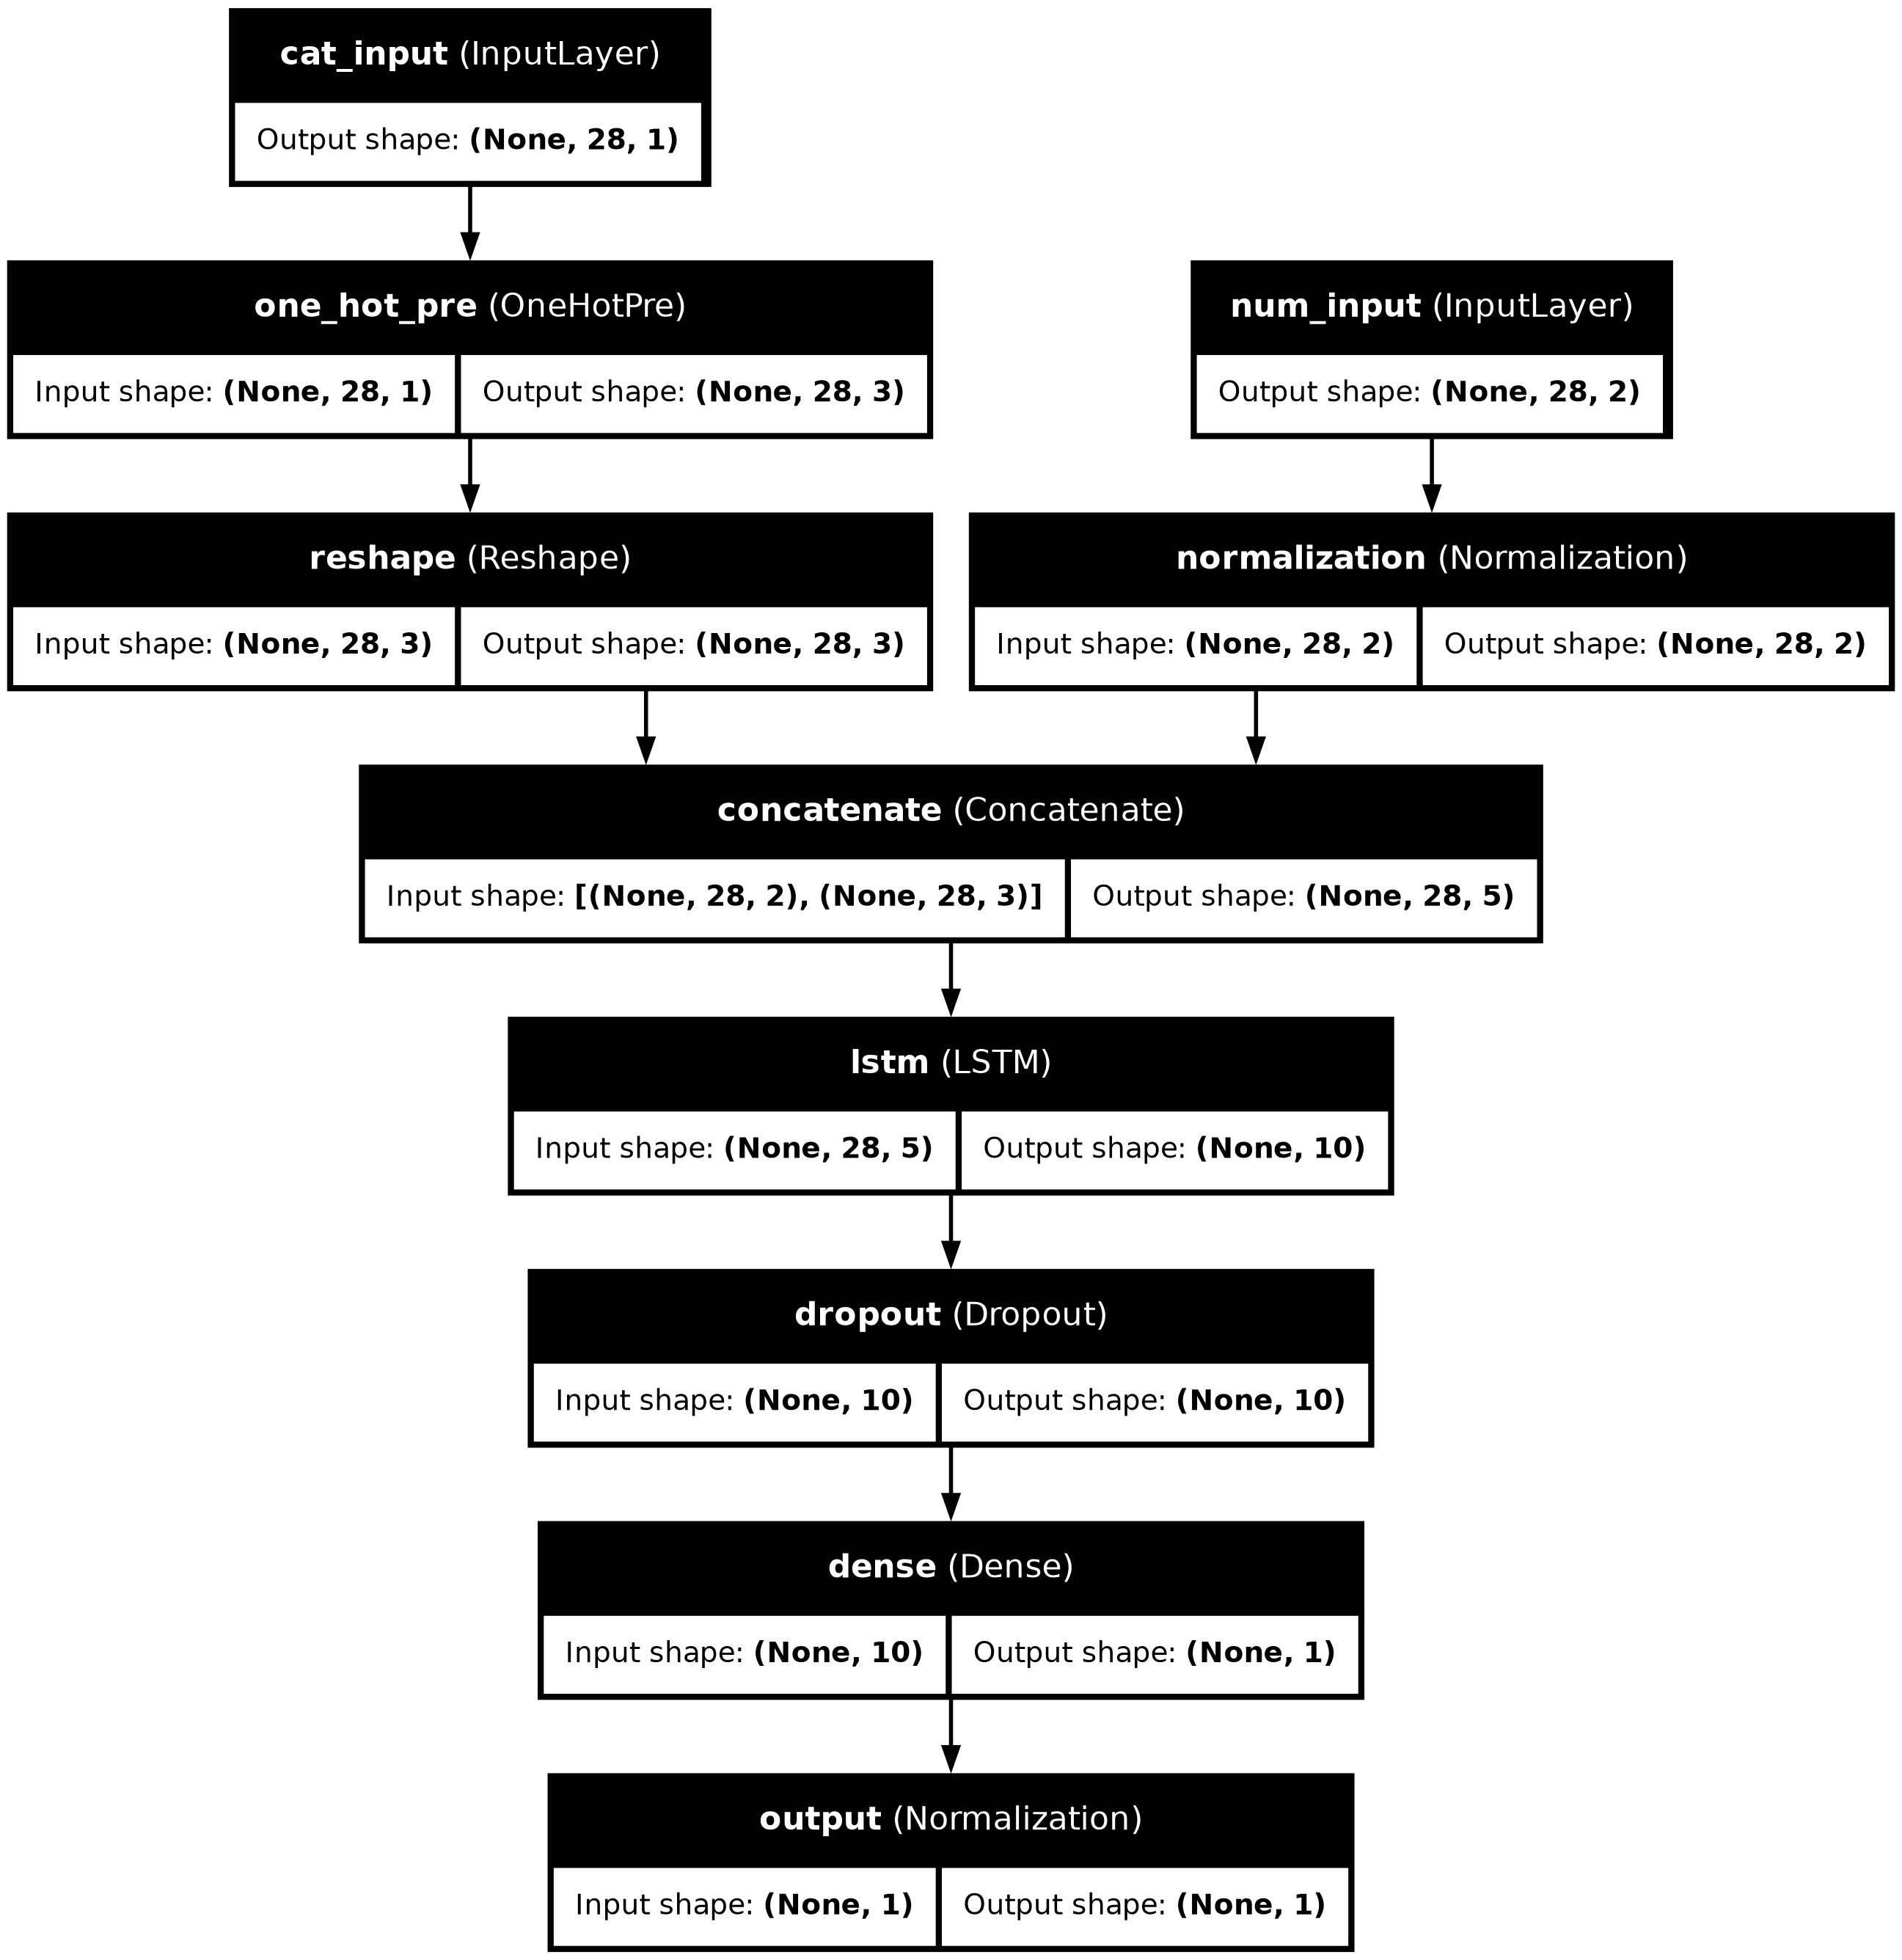

In [16]:
tf.keras.utils.plot_model(model_exo, rankdir="TB", show_shapes=True,  show_layer_names=True)

### Ajuste del modelo

Entrenamos el modelo, es decir, ajustamos los pesos de acuerdo al esquema definido cuando fue compilado, por ejemplo optimizer='Adam'

In [17]:
# Model training
history = model_exo.fit(train_ds, epochs=30, validation_data=val_ds)

# early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
# history = model_exo.fit(train_ds, epochs=3000, validation_data=val_ds, callbacks=[early_stopping_cb])

Epoch 1/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - MAE: 1540.7943 - loss: 3844739.0000 - val_MAE: 1471.8330 - val_loss: 3568811.5000
Epoch 2/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - MAE: 1259.5323 - loss: 2559025.2500 - val_MAE: 1244.7570 - val_loss: 2633027.7500
Epoch 3/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - MAE: 1141.0081 - loss: 2097543.5000 - val_MAE: 1168.5616 - val_loss: 2350017.2500
Epoch 4/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - MAE: 1104.8337 - loss: 2004185.8750 - val_MAE: 1123.7767 - val_loss: 2180346.5000
Epoch 5/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - MAE: 1067.3544 - loss: 1868891.7500 - val_MAE: 1078.9408 - val_loss: 2007799.1250
Epoch 6/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - MAE: 1019.0759 - loss: 1693418.5000 - val_MAE: 1041.4600 - val_loss: 1862328.2500
Epoch 7/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - MAE: 976.5018 - loss: 1591428.0000 - val_MAE: 1007.4163 - val_loss: 1731676.6250
Epoch 8/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - MAE

Para tener una idea sobre la convergencia del moelo, mostramos las curvas de aprendizaje

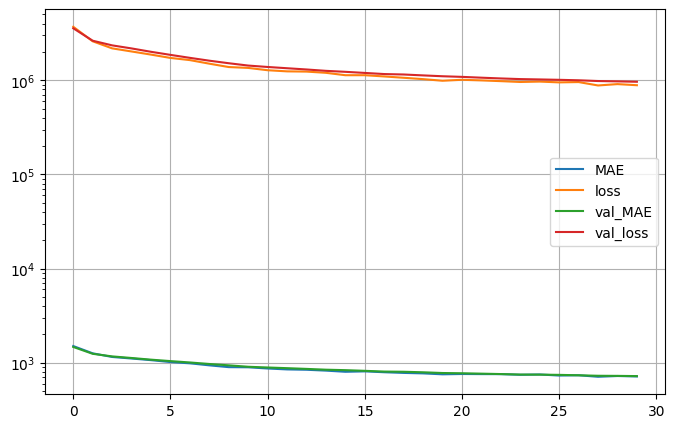

In [18]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.yscale('log')
plt.grid(True)
# plt.gca().set_ylim(0,1)

Luego que el modelo ha sido ajustado, es muy fácil obtener nuevas predicciones, como por ejemplo cuando le pasamos el conjunto de prueba.

In [19]:

# Predict discards targets
predicted_values = model_exo.predict(test_ds)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


In [20]:
predicted_values.shape

(232, 1)

In [21]:
#target_values = test_ds.map(lambda X, y: y['output'])
#target_values = target_values.flat_map(tf.data.Dataset.from_tensor_slices)
#print(type(target_values))
#target_values = np.fromiter(target_values.as_numpy_iterator(), dtype=np.float32)
#print(target_values.shape)

# or
target_values = test_ds.map(lambda X, y: y['output'])
target_values = target_values.unbatch()
print(type(target_values))
target_values = list(target_values.as_numpy_iterator())
print(len(target_values))

<class 'tensorflow.python.data.ops.unbatch_op._UnbatchDataset'>
232


### Evaluación de los resultados

Ahora vamos a representar nuestro resultado. Construimos un `DataFrame` para almacenar los valores de `DEMANDA TOTAL` predecida y observada, y su fecha (que recuperamos de los datos originales). Este `DataFrame` nos facilitará el cálculo de distintas métricas que califican el grado de acuerdo de las predicciones del modelo con los valores registrados. Asimismo, representaremos en una figura ambas series de datos para tener una estimación visual del desempeño del modelo.  

In [22]:
# Forecast Plot with Dates on X-axis
LSTM_eval = pd.DataFrame({
    'Predicted_DEMANDA': predicted_values[:, 0],
    'Actual_DEMANDA': target_values,
})

LSTM_eval.loc[:, 'Date'] = dataFrame['Fecha'][-len(target_values):].values
# LSTM_eval.set_index('Date', inplace=True)
LSTM_eval['Date'] = pd.to_datetime(LSTM_eval['Date'])
LSTM_eval.set_index('Date', inplace=True)


In [23]:
# Creamos una figura para representar las series de datos
def FigPredActual(d, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    #  highlight the  forecast
    # highlight_start = int(len(d) * 0.9)  
    # highlight_end = len(d) - 1  # Adjusted to stay within bounds
    # Plot the actual values
    # plt.plot(d[['Actual_DEMANDA']][:highlight_start], label=['Actual_DEMANDA'])
    plt.plot(d[['Actual_DEMANDA']], label=['Actual_DEMANDA'])
    
    # Plot predicted values with a dashed line
    plt.plot(d[['Predicted_DEMANDA']], label=['Predicted_DEMANDA'], linestyle='--')
    
    # Highlight the forecasted portion with a different color
    # plt.axvspan(d.index[highlight_start], d.index[highlight_end], facecolor='lightgreen', alpha=0.5, label='Forecast')
    
    plt.title(title)
    plt.xlabel('Dates')
    plt.ylabel('Values')
    ax.legend()

Trazamos ambas series de datos

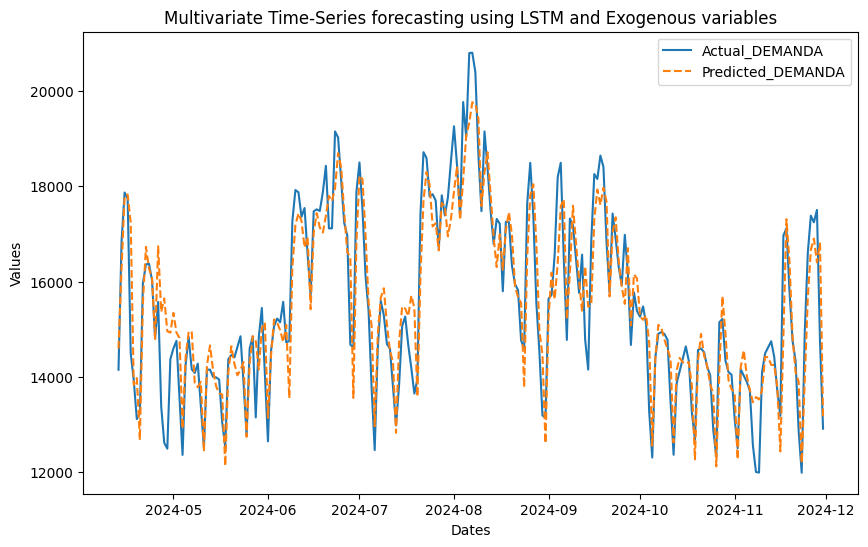

In [24]:
FigPredActual(LSTM_eval, 'Multivariate Time-Series forecasting using LSTM and Exogenous variables')

Definimos una función conveniente para calcular diferentes métrias que nos informan sobre el grado de acuerdo de las predicciones del modelo con las observaciones

In [25]:
# Model Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def performance(d):
    return {
        'MSE': mean_squared_error(d['Actual_DEMANDA'].to_numpy(), d['Predicted_DEMANDA'].to_numpy()),
        'MAE': mean_absolute_error(d['Actual_DEMANDA'].to_numpy(), d['Predicted_DEMANDA'].to_numpy()),
        'R2': r2_score(d['Actual_DEMANDA'].to_numpy(), d['Predicted_DEMANDA'].to_numpy())
    }

performance(LSTM_eval)

{'MSE': np.float64(613143.234298632),
 'MAE': np.float64(580.1424771012931),
 'R2': 0.8344025015830994}

**Preguntas**

1. ¿Por qué el ajuste mejora si `BATCH_SIZE` y `SEQ_LENGTH` coinciden (sin importar demasiado si el número de días corresponde a un número entero de semanas?

**Ejercicio**

1. 